<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais - Exponential Smoothing</font></b></strong>

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime
#from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

pandas      1.1.5
sklearn     0.24.0
numpy       1.19.5
matplotlib  3.3.3
statsmodels 0.12.1
Data Science Academy


## Definição do Problema de Negócio

Previsão do distanciamento social em Minas Gerais.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o distanciamento social em Minas Gerais. Os dados tem registros de 15/02/2020 a 29/01/2021.

Será fornecido 1 dataset com 2 colunas, data e distanciamento social.

In [3]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

Vamos fazer algumas transformações nos dados para criar o modelo.

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2020-02-15,31.6
2020-02-16,38.9
2020-02-17,24.0
2020-02-18,26.5
2020-02-19,27.8


In [5]:
# Tipos de dados
dataframe.dtypes

QT_INTER    float64
dtype: object

In [6]:
# Shape
dataframe.shape

(350, 1)

In [7]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

In [8]:
# Random seed 
np.random.seed(7)

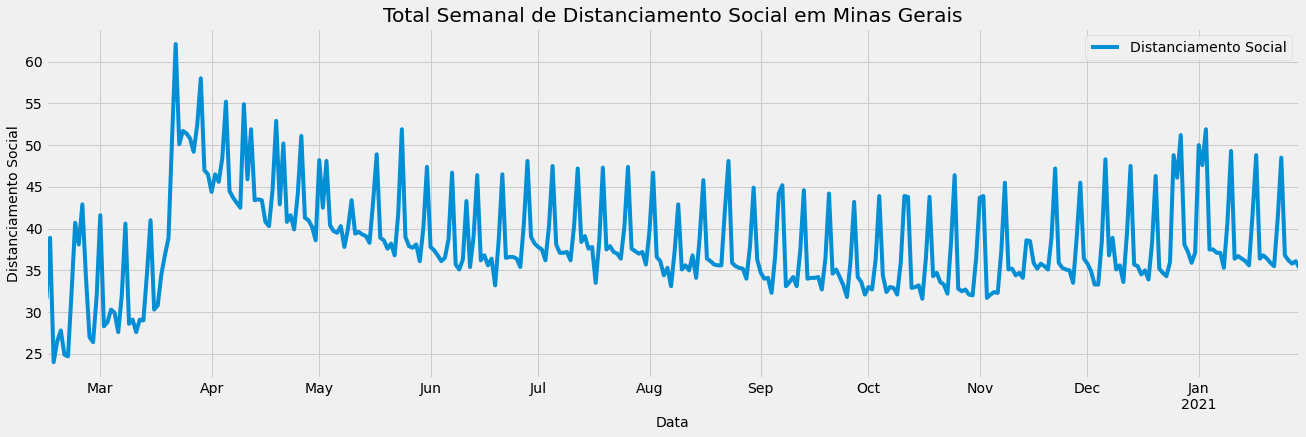

In [10]:
# Plot
target.plot(title = 'Total Semanal de Distanciamento Social em Minas Gerais', fontsize = 14, label = 'Distanciamento Social') 
plt.xlabel("Data") 
plt.ylabel("Distanciamento Social") 
plt.legend(loc = 'best') 
plt.show()

Vamos testar a estacionaridade da série.

In [16]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 10).mean()
    rolstd = serie.rolling(window = 10).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

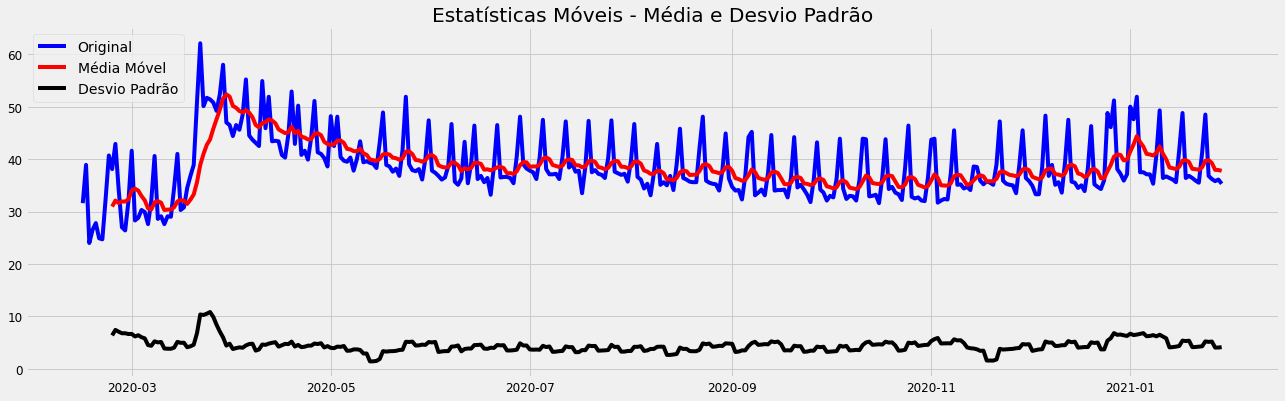


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -3.016851
Valor-p                           0.033350
Número de Lags Consideradas      14.000000
Número de Observações Usadas    335.000000
Valor Crítico (1%)               -3.450022
Valor Crítico (5%)               -2.870207
Valor Crítico (10%)              -2.571387
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [17]:
# Aplica a função 
testa_estacionaridade(dataframe['QT_INTER'])

A série já é estacionária.

Vamos decompor a série e analisar seus componentes em separado.

In [18]:
# Decompondo a série temporal
decomposition = seasonal_decompose(dataframe['QT_INTER'])

In [19]:
# Extraindo cada componente da série
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

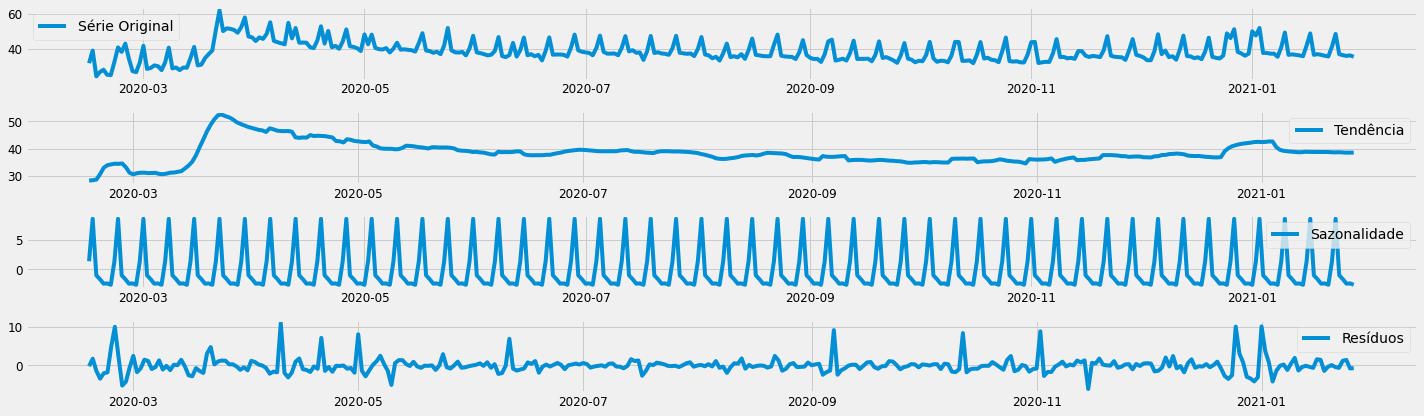

In [20]:
# Plot
plt.subplot(411)
plt.plot(dataframe['QT_INTER'], label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal,label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

# Fim